In [1]:
## Created by Wentinn Liao

# Kalman Filter Research

In [2]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#@title Symlink Setup
import os

def ptpp(PATH: str) -> str: # Converts path to python path
    return PATH.replace('\\', '')

DRIVE_PATH = '/content/gdrive/My\ Drive/KF_RNN'
if not os.path.exists(ptpp(DRIVE_PATH)):
    %mkdir $DRIVE_PATH
SYM_PATH = '/content/KF_RNN'
if not os.path.exists(ptpp(SYM_PATH)):
    !ln -s $DRIVE_PATH $SYM_PATH
%cd $SYM_PATH

/content/gdrive/My Drive/KF_RNN


In [4]:
!pip install numpy imageio matplotlib scikit-learn torch==2.0.0 tensordict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.5/986.5 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [5]:
#@title Configure Jupyter Notebook
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
#@title Library Setup
import time
import json
import pickle
import math
import functools
import numpy as np
import scipy as sc
import sympy as sy
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import *
from argparse import Namespace
import random
import copy
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils as ptu
import torch.optim as optim
import torchdata
import torchvision
from torchvision import datasets, transforms
import tensordict
from tensordict import TensorDict

from model.linear_system import LinearSystem
from model.kf import KF
from model.rnn_kf import RnnKF

from infrastructure import utils
from infrastructure.train import *

# seed = 7
# torch.manual_seed(seed)
# random.seed(seed)
torch.set_default_dtype(torch.double)

dev_type = 'cuda'
if dev_type == 'xla':
    !pip install torch-xla cloud-tpu-client https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl
    import torch_xla
    import torch_xla.core.xla_model as xm

plt.rcParams['figure.figsize'] = (7.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Experimental vs. Analytical Performance

In [8]:
S_D, I_D, O_D, SNR = 6, 6, 4, 2.
dataset_size = 10000
sequence_length = 200

system = LinearSystem.sample_stable_system(Namespace(
    S_D = S_D,
    I_D = I_D,
    O_D = O_D,
    SNR = SNR
))

initial_state = torch.randn(dataset_size, S_D)
input = torch.randn(dataset_size, sequence_length, I_D)

result = system(initial_state, input)
state, observation = result['state'], result['observation']

In [9]:
optimal_kf = KF(system)
result = optimal_kf(initial_state, input, observation)

state_estimation_error = result['state_estimation'] - state
observation_estimation_error = result['observation_estimation'] - observation

experimental_state_covariances, experimental_observation_covariances = [], []
for i in range(sequence_length):
    state_error = state_estimation_error[:, i]
    experimental_state_covariances.append(state_error.T @ state_error / dataset_size)

    observation_error = observation_estimation_error[:, i]
    experimental_observation_covariances.append(observation_error.T @ observation_error / dataset_size)
experimental_state_covariance = torch.stack(experimental_state_covariances)
experimental_observation_covariance = torch.stack(experimental_observation_covariances)

print(Fn.mse_loss(experimental_state_covariance, result['state_covariance']))
print(Fn.mse_loss(experimental_observation_covariance, result['observation_covariance']))

tensor(3.3212e-05)
tensor(0.0122)


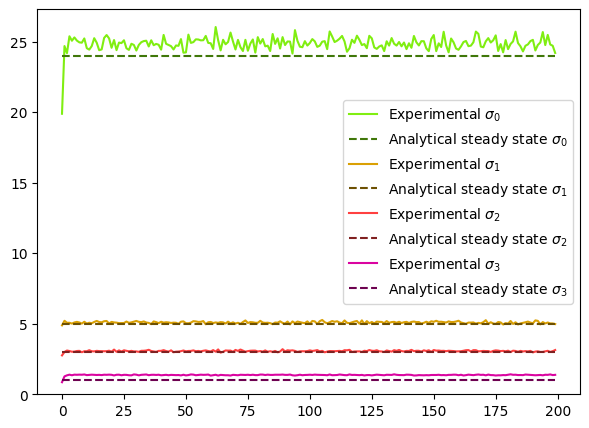

In [13]:
_, analytical_S, _ = torch.linalg.svd(system.S_observation_inf)
_, experimental_S, _ = torch.linalg.svd(experimental_observation_covariance)
for i in range(O_D):
    x = torch.arange(sequence_length)
    c = utils.color(i, scale=2 * O_D)
    plt.plot(x, experimental_S[:, i], color=c, label=f'Experimental $\sigma_{i}$')
    plt.plot(x, torch.full_like(x, analytical_S[i]), color=c / 2, linestyle='--', label=f'Analytical steady state $\sigma_{i}$')
plt.ylim(bottom=0)
plt.legend()
plt.show()

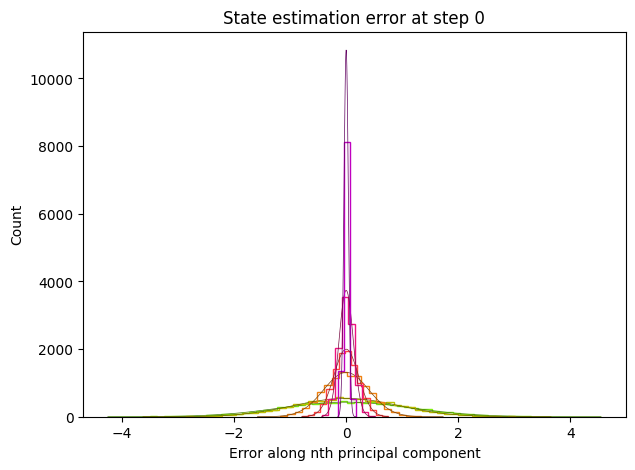

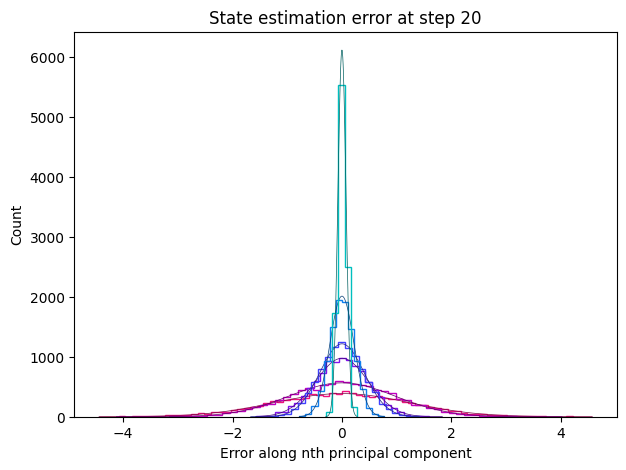

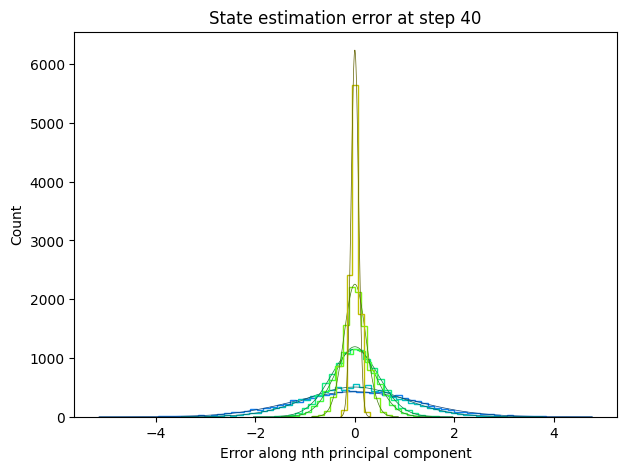

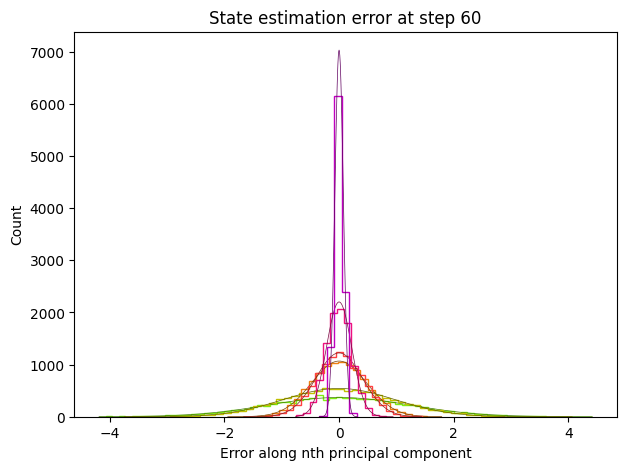

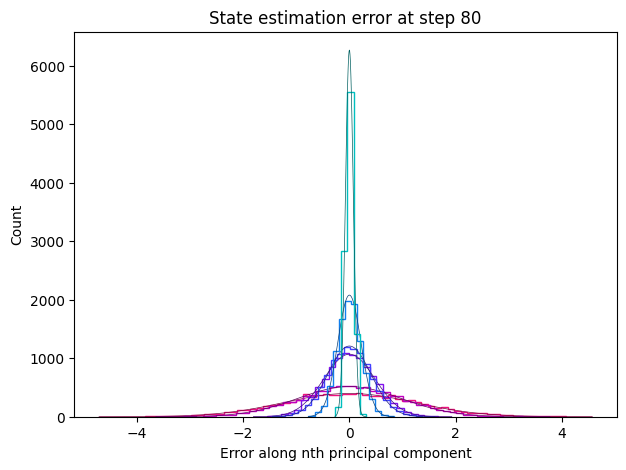

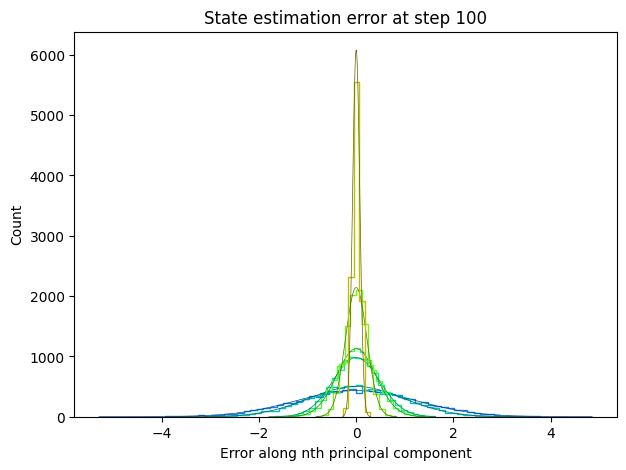

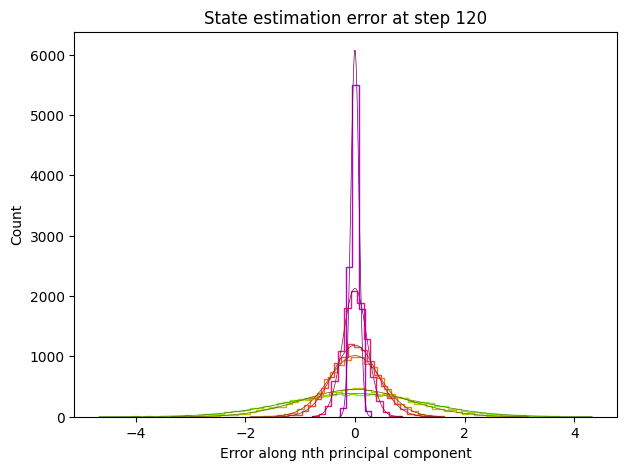

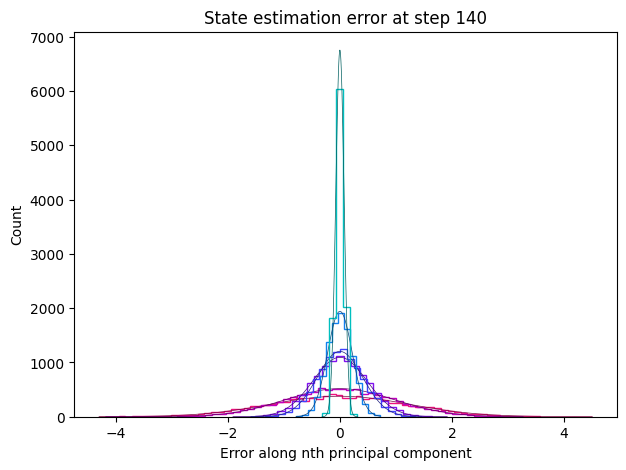

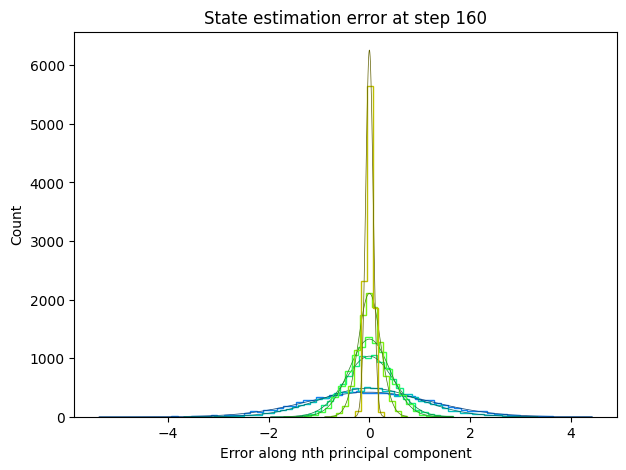

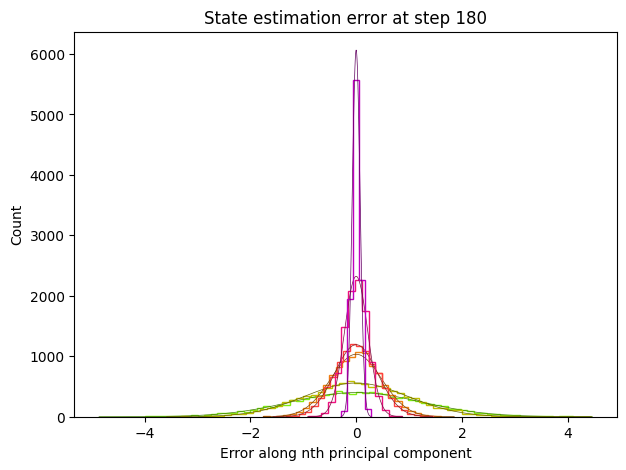

In [14]:
ncols = min(S_D, 8)
for i in range(0, sequence_length, 20):
    U, S, Vh = torch.linalg.svd(result['state_covariance'][i])
    projection = state_estimation_error[:, i] @ U

    x_min, x_max = torch.min(projection, dim=0)[0], torch.max(projection, dim=0)[0]
    for j in range(ncols):
        x = torch.linspace(x_min[j], x_max[j], steps=100)
        c = utils.color(i + j / 2, scale=ncols)
        nbins = math.ceil(60 * torch.sqrt(S[j]))

        _, bins, _ = plt.hist(projection[:, j], color=c, bins=nbins, histtype='step', linewidth=1)
        plt.plot(x, (dataset_size * ((bins[-1] - bins[0]) / nbins) / torch.sqrt(2 * torch.pi * S[j])) * torch.exp(-(x ** 2) / (2 * S[j])), color=c / 2, linewidth=0.5)

    plt.xlabel('Error along nth principal component')
    plt.ylabel('Count')
    plt.title(f'State estimation error at step {i}')
    plt.show()